## Name         :- DARPAN GAUR
## Roll Number  :- CO21BTECH11004

In [29]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time

import torch
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.functional import adaptive_avg_pool2d

In [30]:
# seed 
seed = 17
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
# set device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
# load MINST dataset, train + test as dataset


# define a transform to normalize the data
transform_ = transforms.Compose([transforms.ToTensor()])

# download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform_)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform_)

BATCH_SIZE = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
# DCGAN
class generator(nn.Module):
    def __init__(self, latent_dim=100, img_channel=1, hidden_dim=32):
        super(generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_shape = img_channel
        self.hidden_dim = hidden_dim

        self.convBlock = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, hidden_dim*4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim*4, hidden_dim*2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim*2, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True)
        )
        self.convBlock2 = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, img_channel, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        # x = eps.view(len(eps), self.latent_dim, 1, 1)
        x = self.convBlock(x)
        x = self.convBlock2(x)
        return x
    
class discriminator(nn.Module):
    def __init__(self, img_channel=1, hidden_dim=32):
        super(discriminator, self).__init__()
        self.img_shape = img_channel
        self.hidden_dim = hidden_dim

        self.convBlock = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(hidden_dim*4, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.convBlock(x)
        x = self.convBlock2(x)
        return x.view(-1, 1).squeeze(1)


In [6]:
gen_model = generator().to(device)
dis_model = discriminator().to(device)

In [7]:
criterian = nn.BCELoss()

In [12]:
# train function
def train(gen, dis, trainloader, EPOCHS, LR_G, LR_D, output_dir='./output'):
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=LR_G, betas=(0.5, 0.999))
    optimizer_dis = torch.optim.Adam(dis.parameters(), lr=LR_D, betas=(0.5, 0.999))

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if not os.path.exists(f'{output_dir}/checkpoint'):
        os.makedirs(f'{output_dir}/checkpoint')

    # make log file
    log_file = open(f'{output_dir}/log.txt', 'w')
    
    best_gen_loss = np.inf
    best_dis_loss = np.inf
    for epoch in range(EPOCHS):
        gen.train()
        dis.train()
        gen_loss = 0
        dis_loss = 0
        for i, (real_img, _) in enumerate(tqdm(trainloader)):
            
            
            optimizer_dis.zero_grad()
            real_img = real_img.to(device)

            # train discriminator
            eps = torch.randn(len(real_img), gen.latent_dim, 1, 1).to(device)
            fake_img = gen(eps)

            real_pred = dis(real_img)
            fake_pred = dis(fake_img.detach())

            real_loss = criterian(real_pred, torch.ones_like(real_pred))
            fake_loss = criterian(fake_pred, torch.zeros_like(fake_pred))
            dis_loss = real_loss + fake_loss

            dis_loss.backward()
            optimizer_dis.step()

            optimizer_gen.zero_grad()

            # train generator
            # eps = torch.randn(len(real_img), gen.latent_dim, 1, 1).to(device)
            fake_img = gen(eps)
            fake_pred = dis(fake_img)

            gen_loss = criterian(fake_pred, torch.ones_like(fake_pred))
            gen_loss.backward()
            optimizer_gen.step()

            gen_loss += gen_loss.item()
            dis_loss += dis_loss.item()

        gen_loss /= len(trainloader)
        dis_loss /= len(trainloader)

        print(f'Epoch {epoch+1}/{EPOCHS}, gen_loss: {gen_loss}, dis_loss: {dis_loss}')
        log_file.write(f'Epoch {epoch+1}/{EPOCHS}, gen_loss: {gen_loss}, dis_loss: {dis_loss}\n')

        torch.save(gen.state_dict(), f'{output_dir}/checkpoint/genEPOCH_{epoch+1}.pth')
        torch.save(dis.state_dict(), f'{output_dir}/checkpoint/disEPOCH_{epoch+1}.pth')
    log_file.close()

# train function -> train discriminator k times, train generator 1 time
def train_k(gen, dis, trainloader, EPOCHS, LR_G, LR_D, output_dir='./output', k=1):
    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=LR_G, betas=(0.5, 0.999))
    optimizer_dis = torch.optim.Adam(dis.parameters(), lr=LR_D, betas=(0.5, 0.999))

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if not os.path.exists(f'{output_dir}/checkpoint'):
        os.makedirs(f'{output_dir}/checkpoint')

    # make log file
    log_file = open(f'{output_dir}/log.txt', 'w')
    
    best_gen_loss = np.inf
    best_dis_loss = np.inf
    for epoch in range(EPOCHS):
        gen.train()
        dis.train()
        gen_loss = 0
        dis_loss = 0
        for i, (real_img, _) in enumerate(tqdm(trainloader)):
            for _ in range(k):
                optimizer_dis.zero_grad()
                real_img = real_img.to(device)

                # train discriminator
                eps = torch.randn(len(real_img), gen.latent_dim, 1, 1).to(device)
                fake_img = gen(eps)

                real_pred = dis(real_img)
                fake_pred = dis(fake_img.detach())

                real_loss = criterian(real_pred, torch.ones_like(real_pred))
                fake_loss = criterian(fake_pred, torch.zeros_like(fake_pred))
                dis_loss = real_loss + fake_loss

                dis_loss.backward()
                optimizer_dis.step()

            optimizer_gen.zero_grad()

            # train generator
            eps = torch.randn(len(real_img), gen.latent_dim, 1, 1).to(device)
            fake_img = gen(eps)
            fake_pred = dis(fake_img)

            gen_loss = criterian(fake_pred, torch.ones_like(fake_pred))
            gen_loss.backward()
            optimizer_gen.step()

            gen_loss += gen_loss.item()
            dis_loss += dis_loss.item()

        gen_loss /= len(trainloader)
        dis_loss /= len(trainloader)

        print(f'Epoch {epoch+1}/{EPOCHS}, gen_loss: {gen_loss}, dis_loss: {dis_loss}')
        log_file.write(f'Epoch {epoch+1}/{EPOCHS}, gen_loss: {gen_loss}, dis_loss: {dis_loss}\n')

        torch.save(gen.state_dict(), f'{output_dir}/checkpoint/genEPOCH_{epoch+1}.pth')
        torch.save(dis.state_dict(), f'{output_dir}/checkpoint/disEPOCH_{epoch+1}.pth')

    log_file.close()

## Que 2 (a)

In [41]:
gen_model = generator().to(device)
dis_model = discriminator().to(device)

# train gan for 100 epochs
EPOCHS = 50
LR_G = 0.002
LR_D = 0.002

train(gen_model, dis_model, trainloader, EPOCHS, LR_G, LR_D, output_dir=f'./q2a_{EPOCHS}')

100%|██████████| 235/235 [00:05<00:00, 45.99it/s]


Epoch 1/50, gen_loss: 0.03553692251443863, dis_loss: 0.0033248288091272116


100%|██████████| 235/235 [00:05<00:00, 45.73it/s]


Epoch 2/50, gen_loss: 0.01582167111337185, dis_loss: 0.003378527704626322


100%|██████████| 235/235 [00:05<00:00, 46.10it/s]


Epoch 3/50, gen_loss: 0.01564207300543785, dis_loss: 0.004533188417553902


100%|██████████| 235/235 [00:05<00:00, 45.57it/s]


Epoch 4/50, gen_loss: 0.015923544764518738, dis_loss: 0.0045439680106937885


100%|██████████| 235/235 [00:05<00:00, 45.40it/s]


Epoch 5/50, gen_loss: 0.01925507001578808, dis_loss: 0.00383720058016479


100%|██████████| 235/235 [00:05<00:00, 44.95it/s]


Epoch 6/50, gen_loss: 0.038295477628707886, dis_loss: 0.011484217830002308


100%|██████████| 235/235 [00:05<00:00, 45.82it/s]


Epoch 7/50, gen_loss: 0.017896676436066628, dis_loss: 0.009712438099086285


100%|██████████| 235/235 [00:05<00:00, 46.07it/s]


Epoch 8/50, gen_loss: 0.01643472909927368, dis_loss: 0.00572595139965415


100%|██████████| 235/235 [00:05<00:00, 45.83it/s]


Epoch 9/50, gen_loss: 0.011036022566258907, dis_loss: 0.006235993001610041


100%|██████████| 235/235 [00:05<00:00, 45.39it/s]


Epoch 10/50, gen_loss: 0.005019543692469597, dis_loss: 0.009815276600420475


100%|██████████| 235/235 [00:05<00:00, 45.68it/s]


Epoch 11/50, gen_loss: 0.02107054926455021, dis_loss: 0.006211322266608477


100%|██████████| 235/235 [00:05<00:00, 45.45it/s]


Epoch 12/50, gen_loss: 0.027548883110284805, dis_loss: 0.006000740919262171


100%|██████████| 235/235 [00:05<00:00, 45.71it/s]


Epoch 13/50, gen_loss: 0.042275942862033844, dis_loss: 0.011534081771969795


100%|██████████| 235/235 [00:05<00:00, 45.80it/s]


Epoch 14/50, gen_loss: 0.004350343719124794, dis_loss: 0.007416679989546537


100%|██████████| 235/235 [00:05<00:00, 45.72it/s]


Epoch 15/50, gen_loss: 0.034860290586948395, dis_loss: 0.006226826924830675


100%|██████████| 235/235 [00:05<00:00, 45.50it/s]


Epoch 16/50, gen_loss: 0.010660812258720398, dis_loss: 0.009309547021985054


100%|██████████| 235/235 [00:05<00:00, 45.76it/s]


Epoch 17/50, gen_loss: 0.0075620743446052074, dis_loss: 0.011075836606323719


100%|██████████| 235/235 [00:05<00:00, 45.87it/s]


Epoch 18/50, gen_loss: 0.010094684548676014, dis_loss: 0.005458742380142212


100%|██████████| 235/235 [00:05<00:00, 45.40it/s]


Epoch 19/50, gen_loss: 0.007596781477332115, dis_loss: 0.010825318284332752


100%|██████████| 235/235 [00:05<00:00, 45.74it/s]


Epoch 20/50, gen_loss: 0.005537518300116062, dis_loss: 0.008738705888390541


100%|██████████| 235/235 [00:05<00:00, 45.43it/s]


Epoch 21/50, gen_loss: 0.027050618082284927, dis_loss: 0.0011827803682535887


100%|██████████| 235/235 [00:05<00:00, 45.48it/s]


Epoch 22/50, gen_loss: 0.03955630585551262, dis_loss: 0.006096125114709139


100%|██████████| 235/235 [00:05<00:00, 45.76it/s]


Epoch 23/50, gen_loss: 0.025187542662024498, dis_loss: 0.003721963381394744


100%|██████████| 235/235 [00:05<00:00, 45.49it/s]


Epoch 24/50, gen_loss: 0.022829774767160416, dis_loss: 0.004600395914167166


100%|██████████| 235/235 [00:05<00:00, 45.80it/s]


Epoch 25/50, gen_loss: 0.021246662363409996, dis_loss: 0.0033542688470333815


100%|██████████| 235/235 [00:05<00:00, 43.23it/s]


Epoch 26/50, gen_loss: 0.019792402163147926, dis_loss: 0.003693340579047799


100%|██████████| 235/235 [00:05<00:00, 45.76it/s]


Epoch 27/50, gen_loss: 0.022474681958556175, dis_loss: 0.0027133955154567957


100%|██████████| 235/235 [00:05<00:00, 45.75it/s]


Epoch 28/50, gen_loss: 0.016323812305927277, dis_loss: 0.006470647640526295


100%|██████████| 235/235 [00:05<00:00, 43.79it/s]


Epoch 29/50, gen_loss: 0.007453841157257557, dis_loss: 0.014900031499564648


100%|██████████| 235/235 [00:05<00:00, 42.93it/s]


Epoch 30/50, gen_loss: 0.05297137051820755, dis_loss: 0.007538985460996628


100%|██████████| 235/235 [00:05<00:00, 43.85it/s]


Epoch 31/50, gen_loss: 0.026139266788959503, dis_loss: 0.002544668037444353


100%|██████████| 235/235 [00:05<00:00, 43.74it/s]


Epoch 32/50, gen_loss: 0.02533162571489811, dis_loss: 0.0037275045178830624


100%|██████████| 235/235 [00:05<00:00, 43.91it/s]


Epoch 33/50, gen_loss: 0.025899730622768402, dis_loss: 0.0028074285946786404


100%|██████████| 235/235 [00:05<00:00, 44.24it/s]


Epoch 34/50, gen_loss: 0.03503893315792084, dis_loss: 0.003843120764940977


100%|██████████| 235/235 [00:05<00:00, 43.02it/s]


Epoch 35/50, gen_loss: 0.023494476452469826, dis_loss: 0.0024391801562160254


100%|██████████| 235/235 [00:05<00:00, 45.68it/s]


Epoch 36/50, gen_loss: 0.02748527191579342, dis_loss: 0.002403163118287921


100%|██████████| 235/235 [00:05<00:00, 45.35it/s]


Epoch 37/50, gen_loss: 0.060052257031202316, dis_loss: 0.008007845841348171


100%|██████████| 235/235 [00:05<00:00, 45.67it/s]


Epoch 38/50, gen_loss: 0.02840437740087509, dis_loss: 0.002831505611538887


100%|██████████| 235/235 [00:05<00:00, 45.54it/s]


Epoch 39/50, gen_loss: 0.024506162852048874, dis_loss: 0.009660059586167336


100%|██████████| 235/235 [00:05<00:00, 45.81it/s]


Epoch 40/50, gen_loss: 0.03410797193646431, dis_loss: 0.0020046879071742296


100%|██████████| 235/235 [00:05<00:00, 45.41it/s]


Epoch 41/50, gen_loss: 0.01963159069418907, dis_loss: 0.0031856943387538195


100%|██████████| 235/235 [00:05<00:00, 45.63it/s]


Epoch 42/50, gen_loss: 0.017767062410712242, dis_loss: 0.003314364468678832


100%|██████████| 235/235 [00:05<00:00, 45.39it/s]


Epoch 43/50, gen_loss: 0.037554726004600525, dis_loss: 0.002205194905400276


100%|██████████| 235/235 [00:05<00:00, 45.78it/s]


Epoch 44/50, gen_loss: 0.032819993793964386, dis_loss: 0.002568003023043275


100%|██████████| 235/235 [00:05<00:00, 45.75it/s]


Epoch 45/50, gen_loss: 0.025050967931747437, dis_loss: 0.004190313629806042


100%|██████████| 235/235 [00:05<00:00, 45.39it/s]


Epoch 46/50, gen_loss: 0.03554785996675491, dis_loss: 0.0024533860851079226


100%|██████████| 235/235 [00:05<00:00, 45.66it/s]


Epoch 47/50, gen_loss: 0.03826228901743889, dis_loss: 0.005702832248061895


100%|██████████| 235/235 [00:05<00:00, 45.72it/s]


Epoch 48/50, gen_loss: 0.032495420426130295, dis_loss: 0.0028006427455693483


100%|██████████| 235/235 [00:05<00:00, 45.43it/s]


Epoch 49/50, gen_loss: 0.03793850913643837, dis_loss: 0.002656452124938369


100%|██████████| 235/235 [00:05<00:00, 45.26it/s]


Epoch 50/50, gen_loss: 0.028410831466317177, dis_loss: 0.0022001853212714195


/tmp/ipykernel_617523/2969098414.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load(path))


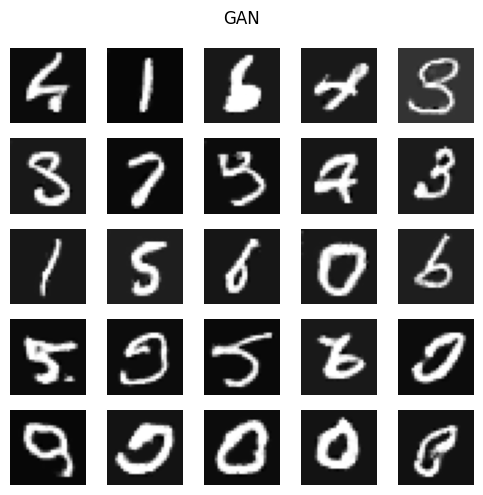

In [94]:
gen_model = generator().to(device)
epoch = 50
path = f'/export/home/darpan/work_dir/h3/q2a_50/checkpoint/genEPOCH_{epoch}.pth'
gen_model.load_state_dict(torch.load(path))

# generate images
gen_model.eval()
n_img = 25
eps = torch.randn(n_img, gen_model.latent_dim, 1, 1).to(device)
fake_img = gen_model(eps)

fig, ax = plt.subplots(5, 5, figsize=(5, 5))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(fake_img[i*5+j].squeeze().detach().cpu().numpy(), cmap='gray')
        ax[i, j].axis('off')
plt.suptitle('GAN')
plt.tight_layout()
plt.savefig(f'ganGenerated')
plt.show()


- Trained the generator and discriminator on the MNIST dataset.
- Trained for 50 epochs, with a batch size of 256, and learning rate of 0.0002.
- Above figure shows the images generated by the generator after 50 epochs.

## Que 2 (b)

In [13]:
gen_model = generator().to(device)
dis_model = discriminator().to(device)

# train gan for 100 epochs
EPOCHS = 20
LR_G = 0.002
LR_D = 0.002

train_k(gen_model, dis_model, trainloader, EPOCHS, LR_G, LR_D, output_dir=f'./q2b_{EPOCHS}_k3', k=3)

100%|██████████| 235/235 [00:06<00:00, 34.18it/s]


Epoch 1/20, gen_loss: 0.049828868359327316, dis_loss: 8.995075040729716e-05


100%|██████████| 235/235 [00:06<00:00, 35.35it/s]


Epoch 2/20, gen_loss: 0.040972862392663956, dis_loss: 0.0009508089278824627


100%|██████████| 235/235 [00:06<00:00, 35.47it/s]


Epoch 3/20, gen_loss: 0.048895761370658875, dis_loss: 0.0007285750471055508


100%|██████████| 235/235 [00:06<00:00, 35.44it/s]


Epoch 4/20, gen_loss: 0.05794839188456535, dis_loss: 0.01761750504374504


100%|██████████| 235/235 [00:06<00:00, 35.69it/s]


Epoch 5/20, gen_loss: 0.042845435440540314, dis_loss: 0.0006785212317481637


100%|██████████| 235/235 [00:06<00:00, 35.66it/s]


Epoch 6/20, gen_loss: 0.04070630297064781, dis_loss: 0.00039003504207357764


100%|██████████| 235/235 [00:06<00:00, 35.49it/s]


Epoch 7/20, gen_loss: 0.04045278578996658, dis_loss: 0.0008282606140710413


100%|██████████| 235/235 [00:06<00:00, 35.53it/s]


Epoch 8/20, gen_loss: 0.02418290264904499, dis_loss: 0.00336423865519464


100%|██████████| 235/235 [00:06<00:00, 35.50it/s]


Epoch 9/20, gen_loss: 0.0182146318256855, dis_loss: 0.011180341243743896


100%|██████████| 235/235 [00:06<00:00, 35.65it/s]


Epoch 10/20, gen_loss: 0.04322927072644234, dis_loss: 0.0012490323279052973


100%|██████████| 235/235 [00:06<00:00, 35.57it/s]


Epoch 11/20, gen_loss: 0.047444898635149, dis_loss: 0.001096071326173842


100%|██████████| 235/235 [00:06<00:00, 35.51it/s]


Epoch 12/20, gen_loss: 0.04438719153404236, dis_loss: 0.0005425330600701272


100%|██████████| 235/235 [00:06<00:00, 35.75it/s]


Epoch 13/20, gen_loss: 0.06608767807483673, dis_loss: 0.0007112949970178306


100%|██████████| 235/235 [00:06<00:00, 35.75it/s]


Epoch 14/20, gen_loss: 0.034539420157670975, dis_loss: 0.000925695348996669


100%|██████████| 235/235 [00:06<00:00, 35.75it/s]


Epoch 15/20, gen_loss: 0.04114539921283722, dis_loss: 0.0009944835910573602


100%|██████████| 235/235 [00:06<00:00, 35.54it/s]


Epoch 16/20, gen_loss: 0.0316220186650753, dis_loss: 0.0005941257695667446


100%|██████████| 235/235 [00:06<00:00, 35.71it/s]


Epoch 17/20, gen_loss: 0.04558362439274788, dis_loss: 0.0004932740121148527


100%|██████████| 235/235 [00:06<00:00, 35.57it/s]


Epoch 18/20, gen_loss: 0.03851314261555672, dis_loss: 0.00015236419858410954


100%|██████████| 235/235 [00:06<00:00, 35.64it/s]


Epoch 19/20, gen_loss: 0.03420773521065712, dis_loss: 0.0009272380266338587


100%|██████████| 235/235 [00:06<00:00, 35.72it/s]


Epoch 20/20, gen_loss: 0.053297337144613266, dis_loss: 0.00030243664514273405


/tmp/ipykernel_617523/743467921.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load(path))


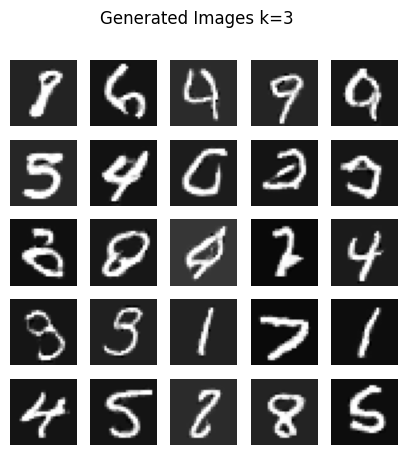

In [77]:
gen_model = generator().to(device)
epoch = 20
path = f'/export/home/darpan/work_dir/h3/q2b_20_k3/checkpoint/genEPOCH_{epoch}.pth'
gen_model.load_state_dict(torch.load(path))

# generate images
gen_model.eval()
n_img = 25
eps = torch.randn(n_img, gen_model.latent_dim, 1, 1).to(device)
fake_img = gen_model(eps)

fig, ax = plt.subplots(5, 5, figsize=(5, 5))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(fake_img[i*5+j].squeeze().detach().cpu().numpy(), cmap='gray')
        ax[i, j].axis('off')
plt.suptitle('Generated Images k=3')
plt.show()

In [19]:
gen_model = generator().to(device)
dis_model = discriminator().to(device)

# train gan for 100 epochs
EPOCHS = 20
LR_G = 0.002
LR_D = 0.0005

train_k(gen_model, dis_model, trainloader, EPOCHS, LR_G, LR_D, output_dir=f'./q2b_{EPOCHS}_k5_2', k=5)

  0%|          | 0/235 [00:00<?, ?it/s]

100%|██████████| 235/235 [00:08<00:00, 29.34it/s]


Epoch 1/20, gen_loss: 0.039777662605047226, dis_loss: 0.00039949986967258155


100%|██████████| 235/235 [00:07<00:00, 29.47it/s]


Epoch 2/20, gen_loss: 0.04405408725142479, dis_loss: 0.00048321878421120346


100%|██████████| 235/235 [00:08<00:00, 29.32it/s]


Epoch 3/20, gen_loss: 0.03816113620996475, dis_loss: 0.0006498092552646995


100%|██████████| 235/235 [00:07<00:00, 29.44it/s]


Epoch 4/20, gen_loss: 0.041274406015872955, dis_loss: 0.0010182354599237442


100%|██████████| 235/235 [00:07<00:00, 29.46it/s]


Epoch 5/20, gen_loss: 0.04676790535449982, dis_loss: 0.0004339235310908407


100%|██████████| 235/235 [00:07<00:00, 29.55it/s]


Epoch 6/20, gen_loss: 0.02754325605928898, dis_loss: 0.0009209508425556123


100%|██████████| 235/235 [00:07<00:00, 29.41it/s]


Epoch 7/20, gen_loss: 0.031951479613780975, dis_loss: 0.000333985808538273


100%|██████████| 235/235 [00:07<00:00, 29.56it/s]


Epoch 8/20, gen_loss: 0.04998793452978134, dis_loss: 0.0009628217667341232


100%|██████████| 235/235 [00:07<00:00, 29.58it/s]


Epoch 9/20, gen_loss: 0.04487496241927147, dis_loss: 0.0007804876659065485


100%|██████████| 235/235 [00:07<00:00, 29.54it/s]


Epoch 10/20, gen_loss: 0.04535688832402229, dis_loss: 0.000567816779948771


100%|██████████| 235/235 [00:07<00:00, 29.50it/s]


Epoch 11/20, gen_loss: 0.03245403990149498, dis_loss: 0.0004705376923084259


100%|██████████| 235/235 [00:07<00:00, 29.47it/s]


Epoch 12/20, gen_loss: 0.04449128359556198, dis_loss: 0.0009733560727909207


100%|██████████| 235/235 [00:07<00:00, 29.56it/s]


Epoch 13/20, gen_loss: 0.03935966640710831, dis_loss: 0.00250041950494051


100%|██████████| 235/235 [00:07<00:00, 29.54it/s]


Epoch 14/20, gen_loss: 0.038385841995477676, dis_loss: 0.001234689261764288


100%|██████████| 235/235 [00:08<00:00, 29.37it/s]


Epoch 15/20, gen_loss: 0.041702620685100555, dis_loss: 0.0002848974836524576


100%|██████████| 235/235 [00:07<00:00, 29.54it/s]


Epoch 16/20, gen_loss: 0.05106460675597191, dis_loss: 0.00043392114457674325


100%|██████████| 235/235 [00:07<00:00, 29.59it/s]


Epoch 17/20, gen_loss: 0.042620010673999786, dis_loss: 0.0003210131835658103


100%|██████████| 235/235 [00:07<00:00, 29.46it/s]


Epoch 18/20, gen_loss: 0.03785616159439087, dis_loss: 0.00019457380403764546


100%|██████████| 235/235 [00:08<00:00, 29.33it/s]


Epoch 19/20, gen_loss: 0.04080851748585701, dis_loss: 0.0002617173595353961


100%|██████████| 235/235 [00:07<00:00, 29.54it/s]


Epoch 20/20, gen_loss: 0.052724383771419525, dis_loss: 0.0005754271405749023


/tmp/ipykernel_617523/346226248.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load(path))


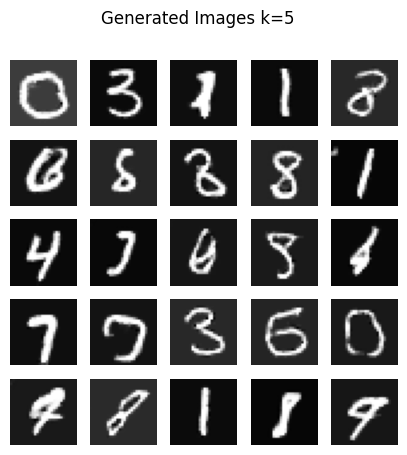

In [78]:
gen_model = generator().to(device)
epoch = 20
path = f'/export/home/darpan/work_dir/h3/q2b_20_k5_2/checkpoint/genEPOCH_{epoch}.pth'
gen_model.load_state_dict(torch.load(path))

# generate images
gen_model.eval()
n_img = 25
eps = torch.randn(n_img, gen_model.latent_dim, 1, 1).to(device)
fake_img = gen_model(eps)


fig, ax = plt.subplots(5, 5, figsize=(5, 5))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(fake_img[i*5+j].squeeze().detach().cpu().numpy(), cmap='gray')
        ax[i, j].axis('off')

plt.suptitle('Generated Images k=5')
plt.show()

- Trained for k=1, k=3 and k=5.
- Above figure shows the images generated by the generator after 50 epochs for k=1, k=3 and k=5.
- For higher values of k, discriminator loss decreases faster, need to adjust the learning rate accordingly.

## Que 2 (c)

In [79]:
# use matplotlib animation to show the generated images
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(4, 4, figsize=(4, 4))

def update(i):
    gen_model.load_state_dict(torch.load(f'./q2a_50/checkpoint/genEPOCH_{i+1}.pth'))
    gen_model.eval()

    eps = torch.randn(16, gen_model.latent_dim, 1, 1).to(device)
    fake_img = gen_model(eps)
    fake_img = fake_img.cpu().detach().numpy()

    fig.suptitle(f'Epoch {i+1}', fontsize=16)

    return fake_img

def init():
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(np.zeros((28, 28)), cmap='gray')
            ax[i, j].axis('off')

def animate(i):
    fake_img = update(i)
    for k in range(4):
        for j in range(4):
            ax[k, j].imshow(fake_img[k*4+j][0], cmap='gray')
            ax[k, j].axis('off')

ani = animation.FuncAnimation(fig, animate, frames=50, init_func=init, interval=1000)
plt.close()
HTML(ani.to_jshtml())


/tmp/ipykernel_617523/3664436739.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load(f'./q2a_50/checkpoint/genEPOCH_{i+1}.pth'))


- Above animation shows generated images after every epoch from random noise.
- By seeing the animation, we can see generate diverse samples of good quality.
- Tried FID score, but due to import error, couldn't calculate it.

## Que 2 (d)

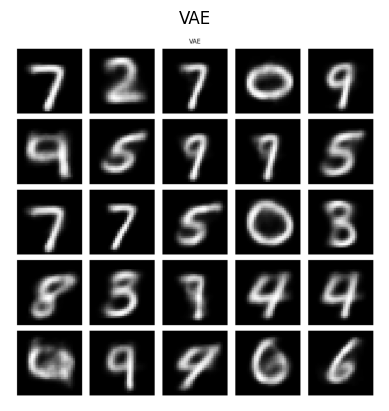

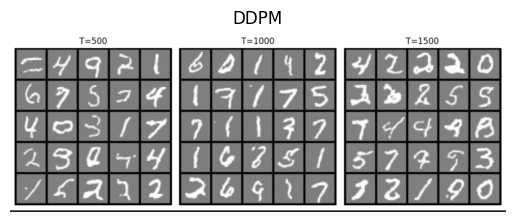

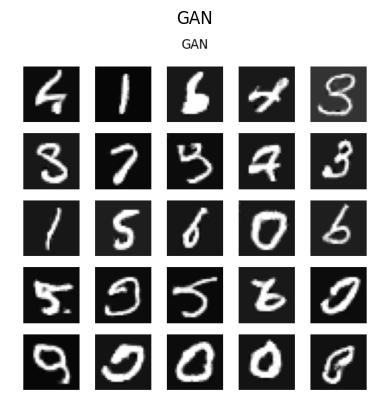

In [95]:
# load image
vae_img = plt.imread('vaeGenerated.png')
ddpm_img = plt.imread('ddpmGenerated.png')
gan_img = plt.imread('ganGenerated.png')

plt.imshow(vae_img)
plt.axis('off')
plt.title('VAE')
plt.show()

plt.imshow(ddpm_img)
plt.axis('off')
plt.title('DDPM')
plt.show()

plt.imshow(gan_img)
plt.axis('off')
plt.title('GAN')
plt.show()

- VAE images are blurred as compared to GAN and DDPM images.
- DDPM images are more sharp and clear as compared GAN images.
- Diversity of images is more in DDPM and VAE as compared to GAN, which can also go to mode collapse sometimes.

## Que 2 (e)

- Mode collapse is a common problem in GANs. It occurs when the generator collapses to a single point, and the discriminator is unable to distinguish between real and fake samples. This results in the generator producing the same output for all inputs.
- When choosing learning rates for the generator and discriminator, it is important to consider the relative learning rates. If the learning rate of the generator is too high, it may cause the generator to collapse to a single point. If the learning rate of the discriminator is too high, it may cause the discriminator to overpower the generator and prevent it from learning.
- If we keep high leraning rate for discriminator as compared to generator, it may cause the generator to collapse.

In [74]:
gen_model = generator().to(device)
dis_model = discriminator().to(device)

# train gan for 100 epochs
EPOCHS = 20
LR_G = 0.0001
LR_D = 0.005

train(gen_model, dis_model, trainloader, EPOCHS, LR_G, LR_D, output_dir=f'./k2')

100%|██████████| 235/235 [00:05<00:00, 44.64it/s]


Epoch 1/20, gen_loss: 0.08504921197891235, dis_loss: 9.174762567454309e-07


100%|██████████| 235/235 [00:05<00:00, 45.04it/s]


Epoch 2/20, gen_loss: 0.057593561708927155, dis_loss: 6.608725379919633e-05


100%|██████████| 235/235 [00:05<00:00, 44.94it/s]


Epoch 3/20, gen_loss: 0.050023939460515976, dis_loss: 9.648030390962958e-05


100%|██████████| 235/235 [00:05<00:00, 45.02it/s]


Epoch 4/20, gen_loss: 0.026957755908370018, dis_loss: 0.001436095335520804


100%|██████████| 235/235 [00:05<00:00, 45.15it/s]


Epoch 5/20, gen_loss: 0.04725557193160057, dis_loss: 0.0005627106875181198


100%|██████████| 235/235 [00:05<00:00, 45.02it/s]


Epoch 6/20, gen_loss: 0.051626380532979965, dis_loss: 7.930531137390062e-05


100%|██████████| 235/235 [00:05<00:00, 44.79it/s]


Epoch 7/20, gen_loss: 0.05768647789955139, dis_loss: 4.1927876736735925e-05


100%|██████████| 235/235 [00:05<00:00, 45.12it/s]


Epoch 8/20, gen_loss: 0.07031242549419403, dis_loss: 1.770359267538879e-05


100%|██████████| 235/235 [00:05<00:00, 44.94it/s]


Epoch 9/20, gen_loss: 0.06147719547152519, dis_loss: 2.6124136638827622e-05


100%|██████████| 235/235 [00:05<00:00, 45.07it/s]


Epoch 10/20, gen_loss: 0.07124879956245422, dis_loss: 1.3175200365367346e-05


100%|██████████| 235/235 [00:05<00:00, 44.77it/s]


Epoch 11/20, gen_loss: 0.0872076153755188, dis_loss: 6.35613760096021e-05


100%|██████████| 235/235 [00:05<00:00, 44.41it/s]


Epoch 12/20, gen_loss: 0.04569271579384804, dis_loss: 0.00012722330575343221


100%|██████████| 235/235 [00:05<00:00, 44.48it/s]


Epoch 13/20, gen_loss: 0.04383723437786102, dis_loss: 0.0003410885692574084


100%|██████████| 235/235 [00:05<00:00, 44.14it/s]


Epoch 14/20, gen_loss: 0.05802706256508827, dis_loss: 4.8459482059115544e-05


100%|██████████| 235/235 [00:05<00:00, 44.44it/s]


Epoch 15/20, gen_loss: 0.05791497230529785, dis_loss: 6.988421955611557e-05


100%|██████████| 235/235 [00:05<00:00, 44.42it/s]


Epoch 16/20, gen_loss: 0.059359267354011536, dis_loss: 4.3941701733274385e-05


100%|██████████| 235/235 [00:05<00:00, 44.42it/s]


Epoch 17/20, gen_loss: 0.04922482743859291, dis_loss: 8.333678124472499e-05


100%|██████████| 235/235 [00:05<00:00, 44.29it/s]


Epoch 18/20, gen_loss: 0.057027418166399, dis_loss: 8.496718510286883e-05


100%|██████████| 235/235 [00:05<00:00, 44.46it/s]


Epoch 19/20, gen_loss: 0.06593916565179825, dis_loss: 1.420719490852207e-05


100%|██████████| 235/235 [00:05<00:00, 44.01it/s]

Epoch 20/20, gen_loss: 0.05970190465450287, dis_loss: 2.864303496608045e-05


/tmp/ipykernel_617523/3000854436.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load(f'./k2/checkpoint/genEPOCH_18.pth'))


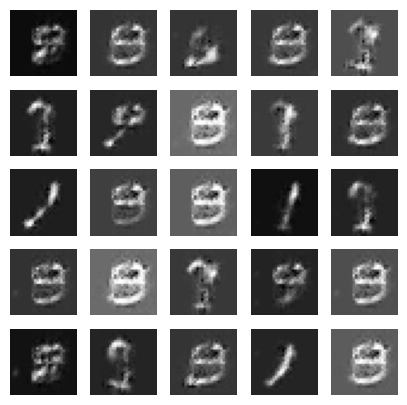

In [91]:
gen_model = generator().to(device)
gen_model.load_state_dict(torch.load(f'./k2/checkpoint/genEPOCH_18.pth'))

gen_model.eval()

n_img = 25
eps = torch.randn(n_img, gen_model.latent_dim, 1, 1).to(device)
fake_img = gen_model(eps)

fig, ax = plt.subplots(5, 5, figsize=(5, 5))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(fake_img[i*5+j].squeeze().detach().cpu().numpy(), cmap='gray')
        ax[i, j].axis('off')

plt.show()

- In the above image only 8 and 1 are generated, which is a sign of mode collapse.